# EXAM May 24 - June 7, 2024 - part 1

## Imports / basic setup

In [1]:
import logging
import threading
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score, make_scorer
import math
from sklearn.feature_selection import VarianceThreshold
import concurrent.futures
from sklearn.metrics import roc_auc_score
from joblib import dump, load
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
random_state = 42
np.random.seed(random_state)
print_lock = threading.Lock()
sns.set(style="darkgrid")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

## Reading data

In [3]:
# read cancer data
X_fish = pd.read_csv('../data/Fish3.txt', delimiter=' ', index_col=0, header=0)
Y_fish = X_fish.pop('Species')

# label map (maps all unique labels with an integer)
label_int_to_str = {i: label for i, label in enumerate(Y_fish.unique())}
label_str_to_int = {label: i for i, label in enumerate(Y_fish.unique())}

In [4]:
print(X_fish.shape, Y_fish.shape)

(1866, 6) (1866,)


In [5]:
print('Features Fish dataset:')
display(X_fish.head())

print('Target Fish dataset:')
display(pd.DataFrame(Y_fish).head())

Features Fish dataset:


Weight         L1         L2         L3     Height      Width
1  170.530305  19.323169  22.913269  23.887829  25.233577  14.826372
2  493.721354  28.299621  31.028229  34.917027  37.856243  13.675772
3   33.657735  17.435741  18.072636  23.489747  26.765675  13.660683
4  584.259843  32.491349  33.126297  39.298082  37.610853  13.622560
5  970.375723  37.122510  39.817489  42.473488  29.878001  17.403387

Target Fish dataset:


Species
1   Perch
2   Bream
3   Roach
4   Bream
5   Perch

## Constants / Functions

In [6]:
scaler = StandardScaler()
variance_thresholder = VarianceThreshold()
smote = SMOTE(random_state=random_state)



n_splits = 5
n_repeats = 5

# Define cross-validation strategy
repeatedStratifiedCV = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

#### Model hyper-parameters

In [7]:
# Hyperparameters
lr_params = {
  'classifier__C': [0.01, 0.1, 1, 10],
}

rf_params = {
  'classifier__n_estimators': [50, 100, 200],
  'classifier__max_depth': [10, 20, None],
  'classifier__min_samples_split': [2, 5],
}

xgb_params = {
  'classifier__n_estimators': [50, 100, 200],
  'classifier__learning_rate': [0.01, 0.1, 1],
  'classifier__max_depth': [3, 5],
}

dt_params = {
  'classifier__max_depth': [5, 10, None],
  'classifier__min_samples_split': [2, 5],
}

svm_params = {
  'classifier__C': [0.1, 1, 10],
  'classifier__kernel': ['linear', 'rbf'],
}

knn_params = {
  'classifier__n_neighbors': [3, 5, 10],
  'classifier__weights': ['uniform', 'distance'],
  'classifier__metric': ['euclidean', 'manhattan'],
}

Reasons why in some models has `class_weight = True`:
- Small weights result in a small penalty and a small update to the model coefficients
- Large weights result in a large penalty and a large update to the model coefficients

In [8]:
# Define models to compare
models_map = {   
  'lr': {
    'model': LogisticRegression(random_state=random_state, class_weight='balanced', n_jobs=-1),
    'params': lr_params,
    'name': 'Logistic Regression',
  },
  
  'rf': {
    'model': RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1),
    'params': rf_params,
    'name': 'Random Forest',
  },
  
  'xgb': {
    'model': XGBClassifier(random_state=random_state, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False),
    'params': xgb_params,
    'name': 'Gradient Boosting',
  },
  
  'dt': {
    'model': DecisionTreeClassifier(random_state=random_state, class_weight='balanced'),
    'params': dt_params,
    'name': 'Decision Tree',
  },
  
  'svm': {
    'model': SVC(random_state=random_state, class_weight='balanced'),
    'params': svm_params,
    'name': 'Support Vector Machine',
  },
  
  'knn': {
    'model': KNeighborsClassifier(),
    'params': knn_params,
    'name': 'K-Nearest Neighbors',
  },
}

### Utilities functions

In [9]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    """
    Split the input data into training, validation, and test sets.

    Parameters:
    - X (array-like): The input features.
    - Y (array-like): The target variable.
    - test_size (float, optional): The proportion of the data to include in the test set. Default is 0.2.
    - validation_set (bool, optional): Whether to include a validation set. Default is False.
    - validation_size (float, optional): The proportion of the data to include in the validation set. Default is 0.2.

    Returns:
    - If validation_set is False:
        - X_train (array-like): The training features.
        - X_test (array-like): The test features.
        - Y_train (array-like): The training target variable.
        - Y_test (array-like): The test target variable.
    - If validation_set is True:
        - X_train (array-like): The training features.
        - X_val (array-like): The validation features.
        - X_test (array-like): The test features.
        - Y_train (array-like): The training target variable.
        - Y_val (array-like): The validation target variable.
        - Y_test (array-like): The test target variable.
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    
    return X_train, X_test, Y_train, Y_test

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches



def plot_class_cv_results(results, title='Fine-tuned models Comparison per class'):
    # metrics to be plotted, per class
    metrics_names = {
        'f1': 'F1 Score',
        'sensitivity': 'Sensitivity',
        'specificity': 'Specificity'
    }
    metrics_colors = {
        'f1': 'skyblue',
        'sensitivity': 'lightgreen',
        'specificity': 'lightcoral'
    }

    # Initialize dictionary to store results for each metric,   
    # for each class, for each model
    metrics_results = {
        model: {
            class_label: {
                metric: [] for metric in metrics_names.keys()
            } 
            for class_label in label_int_to_str.keys()
            
        } 
        for model in results.keys()
    }

    # Extract the results for each metric and each model
    for model, result in results.items():
        for class_label in label_int_to_str.keys():
            for metric in metrics_names.keys():
                metrics_results[model][class_label][metric] = np.array(get_results_across_cvs(
                    result['grid_search_res'], 
                    f'{metric}_class_{label_int_to_str[class_label]}'
                )).mean()
                
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 7), sharey=True)
    
    # Define the width of each bar and the positions
    width = 0.2
    x = np.arange(len(label_int_to_str))
    
    # Plot bars for each metric
    for ax, (model, model_results) in zip(axes.flatten(), metrics_results.items()):
        ax.set_title(models_map[model]['name'])
        for i, (class_label, class_results) in enumerate(model_results.items()):
            for j, (metric, metric_name) in enumerate(metrics_names.items()):
                position = i + j * width - width
                height = class_results[metric]
                ax.bar(
                    x=position,
                    height=height, 
                    width=width,
                    label=metric_name if i == 0 else "",  # Only label the first group to avoid duplicates
                    color=metrics_colors[metric]
                )
                
                ax.text(
                    position, 
                    height / 2,
                    f'{height:.2f}', 
                    ha='center', 
                    va='center', 
                    rotation=90, 
                    color='black', 
                    fontsize='small'
                )
        ax.set_xticks(x)
        ax.set_xticklabels(label_int_to_str.values())
                
    fig.suptitle(title, fontsize=16)
    fig.legend(metrics_names.values(), loc='upper left', frameon=False, fontsize='large', bbox_to_anchor=(0.02, 1))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def plt_decision_boundary(X_train, Y_train, results, title):
    # Number of subplots (2 rows and 3 columns)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each model
    for i, model_key in enumerate(models_map.keys()):
        best_model = results[model_key]['grid_search_res'].best_estimator_
        
        # Create a pipeline for visualization with LDA
        visualization_pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Use the same scaler
            ('lda', LinearDiscriminantAnalysis(n_components=2)),
            ('classifier', best_model)
        ])
        
        # Fit the pipeline
        visualization_pipeline.fit(X_train, Y_train)
        
        # Transform the training data using the fitted LDA
        X_train_lda = visualization_pipeline.named_steps['lda'].transform(
            visualization_pipeline.named_steps['scaler'].transform(X_train)
        )

        # Plot the decision boundary
        ax = axes[i]
        plot_decision_regions(
            X_train_lda, 
            Y_train.values, 
            clf=visualization_pipeline.named_steps['classifier'], 
            legend=2, 
            ax=ax,
            scatter_kwargs={'edgecolor': None}
        )
        
        # set the actual label names in the legend
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, label_int_to_str.values())
        
        ax.set_title(f'{models_map[model_key]['name']}')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    # Adjust layout
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(Y_test, Y_pred, labels, model_name, text=''):
    sns.set_style("dark")
    
    # confusion matrix and display
    cm = confusion_matrix(Y_test, Y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    cm_display.plot()
    plt.title(f'Confusion matrix for test data (model: {model_name}, {text})')
    plt.show()
    sns.set_style("darkgrid")

def get_results_across_cvs(grid_results, score):
    grid_results_df = pd.DataFrame(grid_results.cv_results_)
    best_params = grid_results.best_params_
    best_index = grid_results_df.query('params == @best_params').index[0]
    score_across_cvs = [grid_results_df.loc[best_index, f'split{i}_test_{score}'] for i in range(n_splits * n_repeats)]
            
    return score_across_cvs
    
def plot_cv_results(results, title='Model Comparison'):
    # Metrics to be plotted
    metrics = {
        'f1_score': 'F1 Score (Macro)',
        'sensitivity_score': 'Sensitivity (Macro)',
        'specificity_score': 'Specificity (Macro)'
    }
    
    # Initialize dictionary to store results for each metric
    metrics_results = {metric: {} for metric in metrics}
    
    # Extract the results for each metric and each model
    for _, result in results.items():
        model_name = result['model_name']
        for metric in metrics:
            metrics_results[metric][model_name] = get_results_across_cvs(
                result['grid_search_res'], metric
            )
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
    
    # Plot box plots for each metric
    for ax, (metric, label) in zip(axes, metrics.items()):
        data = list(metrics_results[metric].values())
        labels = list(metrics_results[metric].keys())
        
        # Create the box plot
        bplot = ax.boxplot(data, labels=labels, showmeans=True)
        
        # Calculate and plot the mean score for each model
        for i, model_data in enumerate(data):
            mean_val = np.mean(model_data)
            ax.text(i + 1, np.max(model_data) + 0.005, f'{mean_val:.2f}', horizontalalignment='center', color='green')
        
        ax.set_title(label)
        ax.set_ylabel(label)
        ax.set_xticklabels(labels, rotation=45)
    
    fig.suptitle(title, fontsize=16)
    
    custom_text = mpatches.Patch(color='green', label='Mean Score (e.g., 0.XX)')
    fig.legend(handles=[custom_text], loc='upper left', frameon=False, fontsize='large', bbox_to_anchor=(0.02, 1))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
                
def show_results_summary(results):
    # Print results summary in a tabular format (using pandas DataFrame)
    results_summary = []
    for _, result in results.items():
        results_summary.append({
            'Model': result['model_name'],
            f'CV f1 score (macro)': result['grid_search_res'].cv_results_['mean_test_f1_score'].mean(),
            f'Test f1 score (macro)': result['test_f1_score'],
            
        })
         
    results_df = pd.DataFrame(results_summary)
    results_df.columns = ['Model', f'CV F1 score (macro)', f'Test F1 score (macro)']
    results_df.index = results_df['Model']
    results_df.drop(columns=['Model'], inplace=True)
    results_df = results_df.T

    display(results_df)
    
def show_classification_report(Y_test, Y_pred, model_name: str, text=''):
  print(f"Classification Report for test data ({text}, model: {model_name}) \n {classification_report(Y_test, Y_pred, target_names=label_int_to_str.values())}")
  


### Main / wrapper functions

In [11]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from imblearn.pipeline import Pipeline
from imblearn.metrics import sensitivity_score, specificity_score

def run_grid_search(X_train, Y_train, model_info, imb_handler=None):
    model = model_info['model']
    params = model_info['params']
    pipeline_steps = []
    
    
    if imb_handler:
        pipeline_steps.append(('imb_handler', imb_handler))
    
    pipeline_steps.append(('scaler', scaler))
    pipeline_steps.append(('classifier', model))
    
    pipeline = Pipeline(steps=pipeline_steps)

    scorings = {
        'sensitivity_score': make_scorer(sensitivity_score, average='macro'),
        'specificity_score': make_scorer(specificity_score, average='macro'),
        'f1_score': make_scorer(f1_score, average='macro'),
    }
    
    # scorings per class
    for label, i in label_str_to_int.items():
        scorings[f'f1_class_{label}'] = make_scorer(f1_score, average=None, labels=[i])
        scorings[f'sensitivity_class_{label}'] = make_scorer(sensitivity_score, average=None, labels=[i])
        scorings[f'specificity_class_{label}'] = make_scorer(specificity_score, average=None, labels=[i])

    # Perform grid search
    grid_search_res = GridSearchCV(
        pipeline, 
        params, 
        scoring=scorings, 
        cv=repeatedStratifiedCV,
        refit='f1_score', # it has to be one of the keys in scorings
        n_jobs=-1
    )
    grid_search_res.fit(X_train, Y_train)      
    
    return grid_search_res

In [12]:
def process_model(model_key, model_info, X_train, X_test, Y_train, Y_test, imb_handler=None):
    ''' Best parameters for a given algorithm. '''
    # grid search to get best model/parameters for given algorithm
    grid_search_res = run_grid_search(X_train, Y_train, model_info, imb_handler=imb_handler)
    Y_test_pred = grid_search_res.predict(X_test)
    
    # metrics on the test data
    test_f1_macro_score = f1_score(Y_test, Y_test_pred, average='macro')
        
    # prepare log messages
    log_messages = [
        f"Best parameters found for {model_info['name']}: {grid_search_res.best_params_}",
        f"Best CV f1-macro score: {grid_search_res.best_score_}",
        f'Test f1 macro Score: {test_f1_macro_score}',
    ]

    # return info
    return {
        'model_key': model_key,
        'model_name': model_info["name"], 
        'grid_search_res': grid_search_res,
        'test_f1_score': test_f1_macro_score.mean(),
        'Y_test_pred': Y_test_pred,
        'log_messages': log_messages,
    }

In [13]:
def run_main(model_map, X_train, X_test, Y_train, Y_test, imb_handler=None, prints=True, label_names=label_int_to_str.values()):
    results = {} # keys are model keys and values are results dictionaries
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        
        futures = {}
        for model_key, model_info in model_map.items():
            future = executor.submit(process_model, model_key, model_info, X_train, X_test, Y_train, Y_test, imb_handler)
            futures[future] = model_key
        
        for future in concurrent.futures.as_completed(futures):
            model_key = futures[future]
            result = future.result()
            results[model_key] = result
        
        if prints:
            # print results summary
            with print_lock:
                print('\n\n**************************************************')
                print('**RESULTS SUMMARY**\n')
                show_results_summary(results)
                print('**************************************************\n\n')
                
            # print results for each model
            for _, result in results.items():
                # log results
                with print_lock:
                    print('--------------------------------------------------')
                    for message in result['log_messages']:
                        print(message)
                    plot_confusion_matrix(Y_test, result['Y_test_pred'], label_names, result['model_name'])
                    show_classification_report(Y_test, result['Y_test_pred'], result['model_name'])
                    print('--------------------------------------------------\n\n')
                    
    return results

## Exploratory data analysis (EDA)

In [14]:
# split data
# map the labels to integers
Y_fish = Y_fish.map(label_str_to_int)
X_train, X_test, Y_train, Y_test = splits(X_fish, Y_fish, test_size=0.2, validation_set=False)

Y_train_labeled = Y_train.map(label_int_to_str)

In [20]:
# check for class imbalance
print('Class distribution:')
df_imb = pd.DataFrame({'count': Y_train_labeled.value_counts(), 'percentage': round(Y_train_labeled.value_counts(normalize=True), 2)}).T
display(df_imb)

# export it as a latex table
latex_table = df_imb.to_latex(index=False, caption='Class distribution, in terms of counting and proportion', label='tab:class-distr', column_format='|c|c|c|')
print(latex_table)

Class distribution:


Species      Bream  Perch  SilverBream    Pike   Smelt   Roach  Whitewish
count       433.00  299.0       193.00  189.00  175.00  170.00      33.00
percentage    0.29    0.2         0.13    0.13    0.12    0.11       0.02

\begin{table}
\caption{Class distribution, in terms of counting and proportion}
\label{tab:class-distr}
\begin{tabular}{|c|c|c|}
\toprule
Bream & Perch & SilverBream & Pike & Smelt & Roach & Whitewish \\
\midrule
433.000000 & 299.000000 & 193.000000 & 189.000000 & 175.000000 & 170.000000 & 33.000000 \\
0.290000 & 0.200000 & 0.130000 & 0.130000 & 0.120000 & 0.110000 & 0.020000 \\
\bottomrule
\end{tabular}
\end{table}



Class distribution:


count  percentage
Species                       
Bream          433    0.290214
Perch          299    0.200402
SilverBream    193    0.129357
Pike           189    0.126676
Smelt          175    0.117292
Roach          170    0.113941
Whitewish       33    0.022118

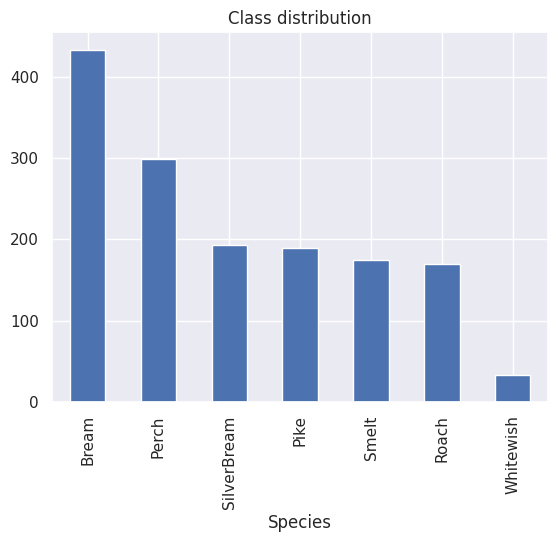

In [125]:
# bar plot of class distribution
Y_train_labeled.value_counts().plot(kind='bar', title='Class distribution')
plt.show()

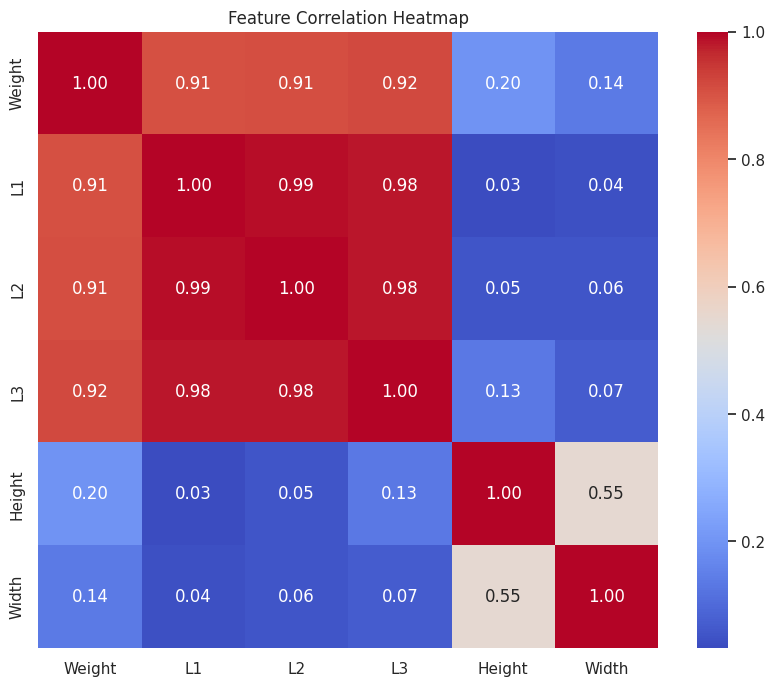

In [126]:
# check the feature correlation
corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
plt.title('Feature Correlation Heatmap')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

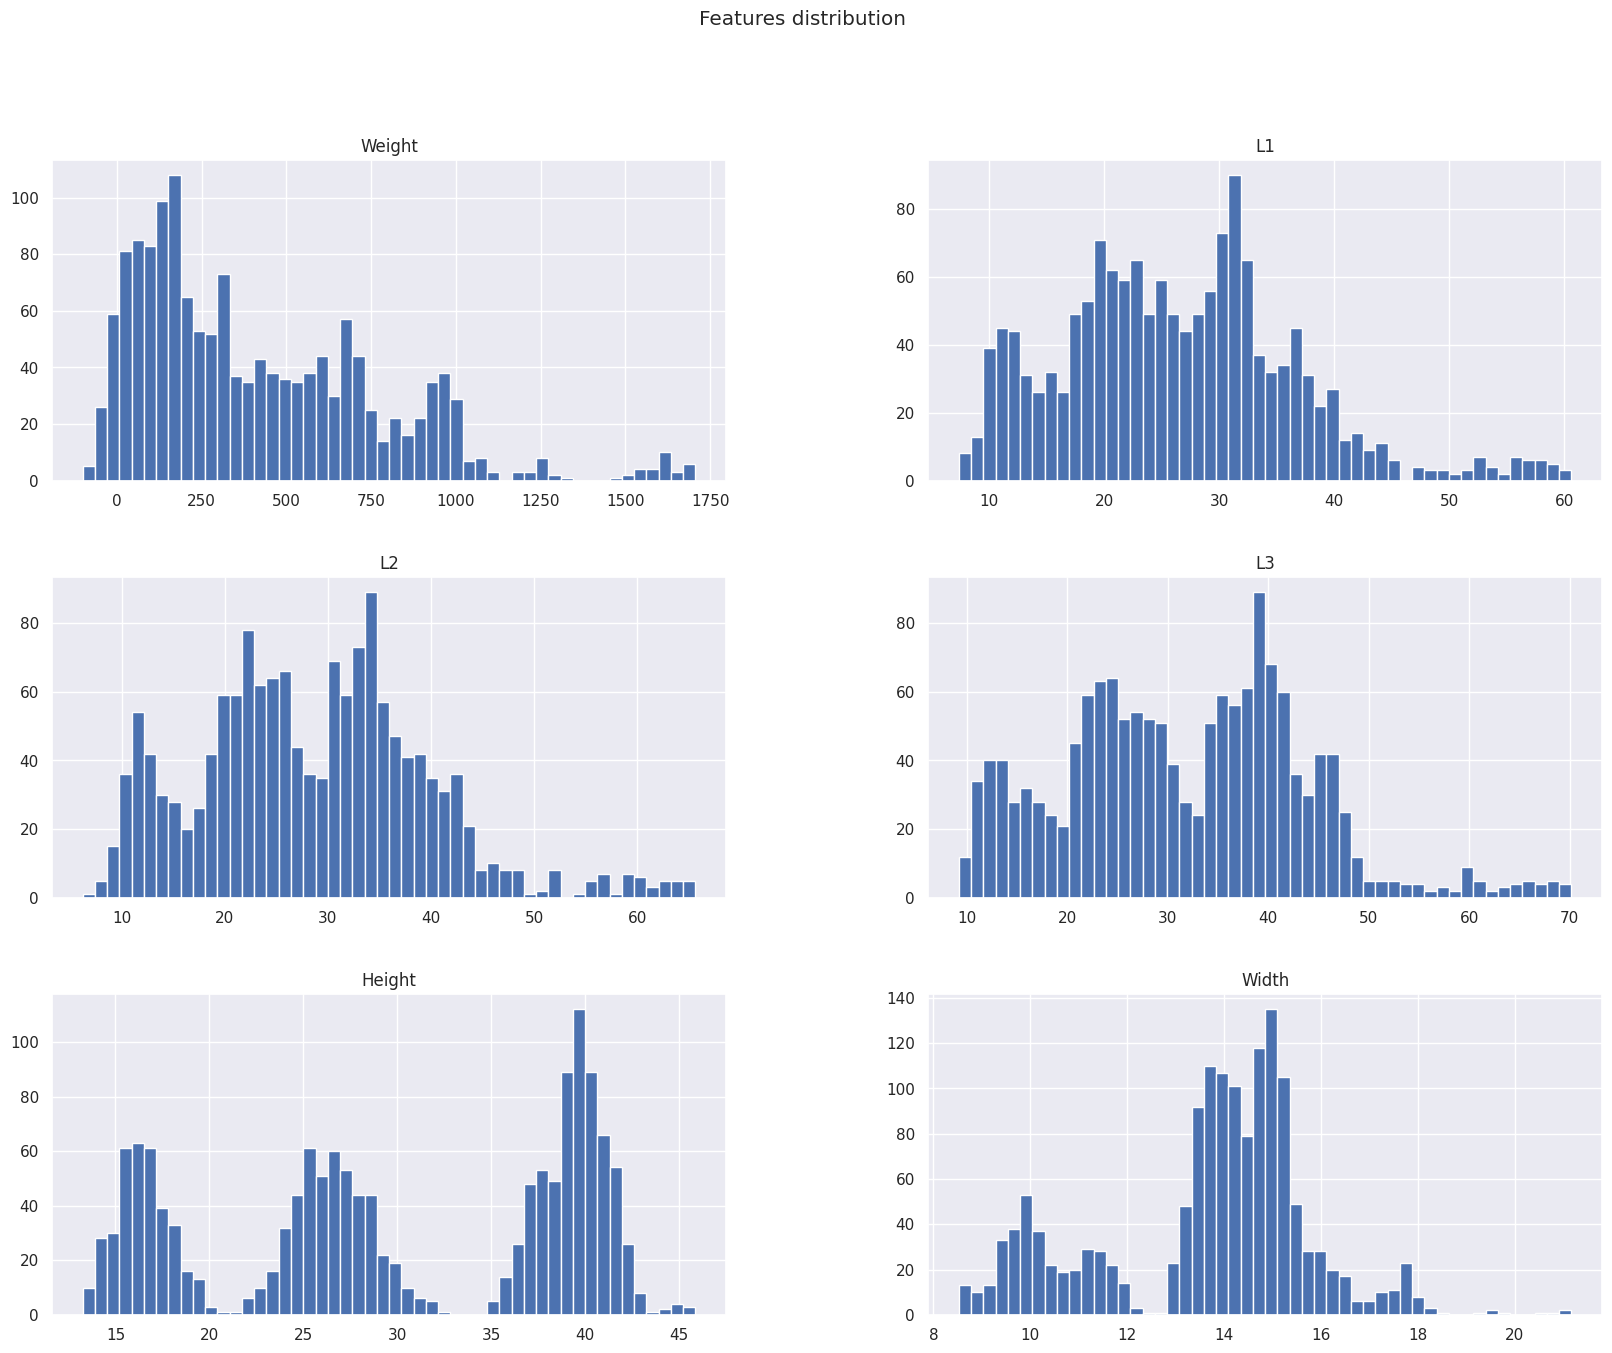

In [127]:
# features distribution
X_train.hist(bins=50, figsize=(20, 15))
plt.suptitle('Features distribution')
plt.show()

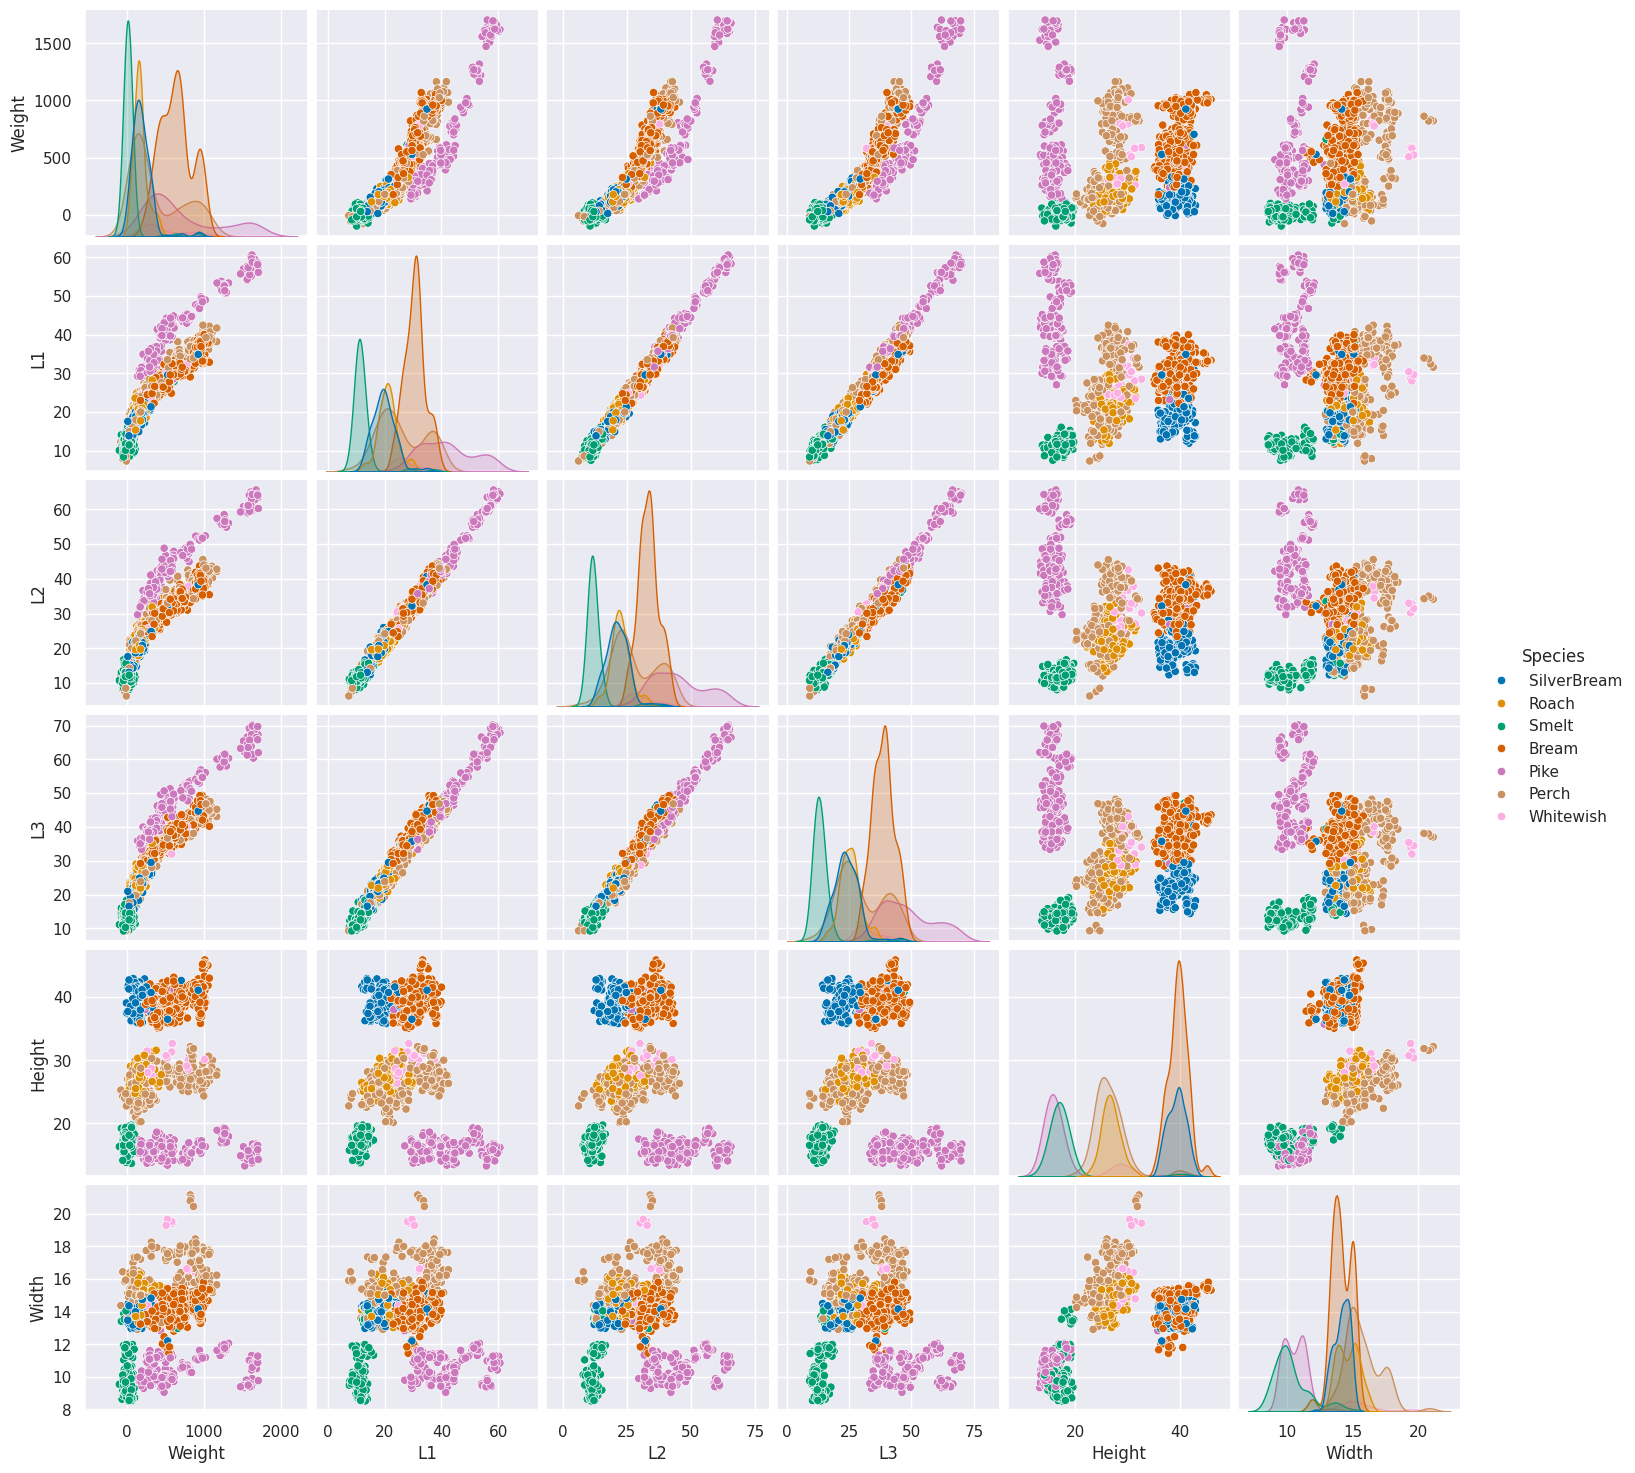

In [128]:
# pairplot of the features
sns.pairplot(pd.concat([X_train, Y_train_labeled], axis=1), hue='Species', palette='colorblind')

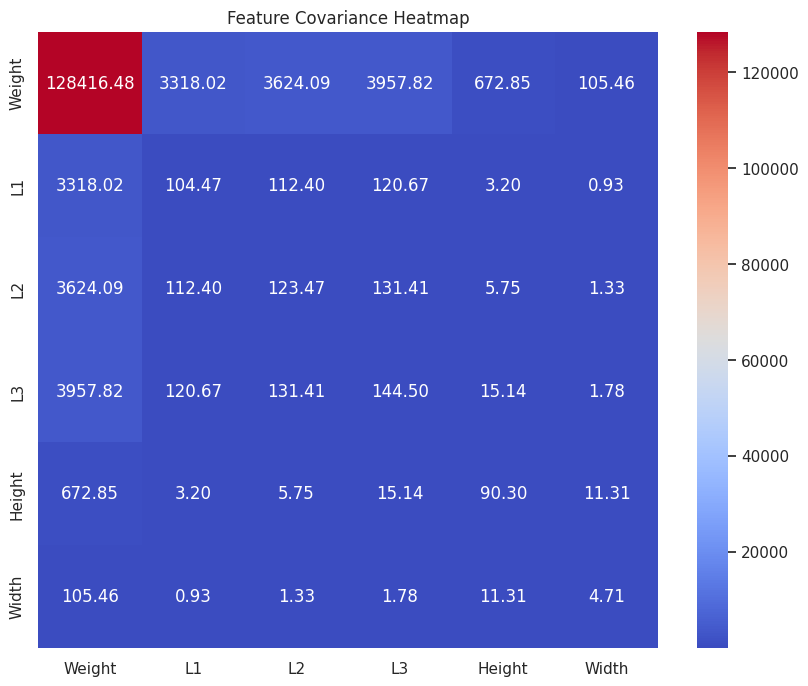

In [129]:
# check features covariance
cov_matrix = X_train.cov()
plt.figure(figsize=(10, 8))
plt.title('Feature Covariance Heatmap')
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Other than PCA, we use LDA for the the linearity between most of the features.


Linear discriminant analysis is very similar to PCA both look for linear combinations of the features which best explain the data.

The main difference is that the Linear discriminant analysis is a supervised dimensionality reduction technique that also achieves classification of the data simultaneously.

    LDA focuses on finding a feature subspace that maximizes the separability between the groups.

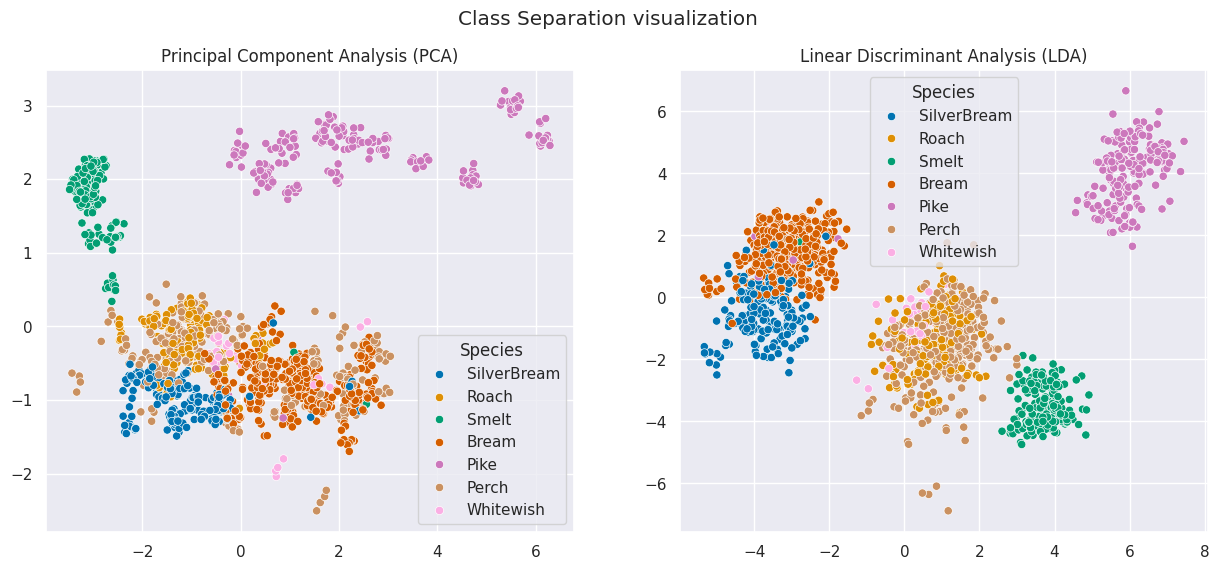

In [130]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# scale the data first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_train_scaled, Y_train)

# Plot PCA and LDA scatter plots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot PCA scatter plot
axs[0].set_title('Principal Component Analysis (PCA)')
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Y_train_labeled, ax=axs[0], palette='colorblind')

# Plot LDA scatter plot
axs[1].set_title('Linear Discriminant Analysis (LDA)')
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=Y_train_labeled, ax=axs[1] , palette='colorblind')

fig.suptitle('Class Separation visualization')
plt.show()

## 1a: training and prediction perormance

The performance will be assed by using f1 score (but also the balanced accuracy will be shown, for multiple metrics assessments in cv performance). It will be also shown the classification report for a more detailed inspection on the scores per classes.

- Overall performance and how you assess this
- Are all or only some classes well separated
- Class imbalance, modeling assumptions, training metrics
- The full training pipeline you set up and motivate all your choices: standardScaler --> SMOTE --> estiamtor with gridCV repeaterStratifiedKFold (5 folds, 3 times)

### Without over/under sampling



**************************************************
**RESULTS SUMMARY**



Model                  Logistic Regression  Decision Tree  \
CV F1 score (macro)               0.725116       0.808736   
Test F1 score (macro)             0.765422       0.877330   

Model                  Support Vector Machine  K-Nearest Neighbors  \
CV F1 score (macro)                  0.774651             0.881871   
Test F1 score (macro)                0.862037             0.915186   

Model                  Gradient Boosting  Random Forest  
CV F1 score (macro)             0.823732       0.861420  
Test F1 score (macro)           0.870659       0.906578

**************************************************


--------------------------------------------------
Best parameters found for Logistic Regression: {'classifier__C': 10}
Best CV f1-macro score: 0.755418558482437
Test f1 macro Score: 0.7654223649180372


<Figure size 1200x800 with 0 Axes>

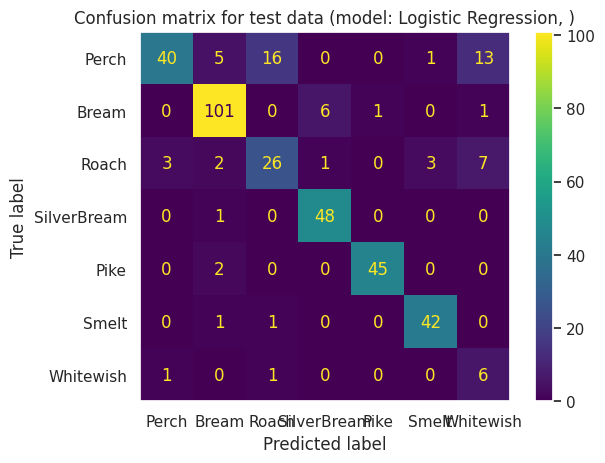

Classification Report for test data (, model: Logistic Regression) 
               precision    recall  f1-score   support

       Perch       0.91      0.53      0.67        75
       Bream       0.90      0.93      0.91       109
       Roach       0.59      0.62      0.60        42
 SilverBream       0.87      0.98      0.92        49
        Pike       0.98      0.96      0.97        47
       Smelt       0.91      0.95      0.93        44
   Whitewish       0.22      0.75      0.34         8

    accuracy                           0.82       374
   macro avg       0.77      0.82      0.77       374
weighted avg       0.86      0.82      0.83       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best CV f1-macro score: 0.8235932237120199
Test f1 macro Score: 0.8773303022234618


<Figure size 1200x800 with 0 Axes>

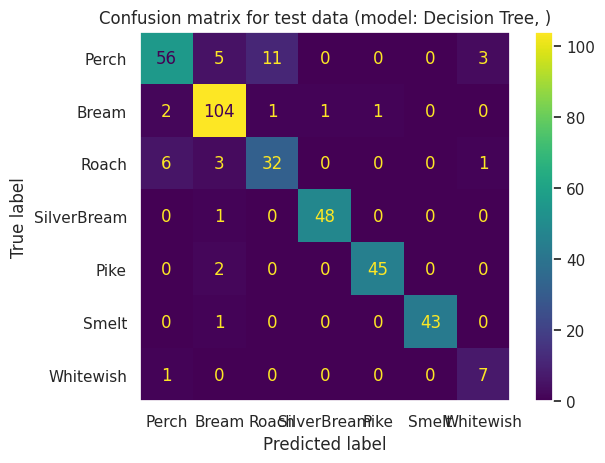

Classification Report for test data (, model: Decision Tree) 
               precision    recall  f1-score   support

       Perch       0.86      0.75      0.80        75
       Bream       0.90      0.95      0.92       109
       Roach       0.73      0.76      0.74        42
 SilverBream       0.98      0.98      0.98        49
        Pike       0.98      0.96      0.97        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.64      0.88      0.74         8

    accuracy                           0.90       374
   macro avg       0.87      0.89      0.88       374
weighted avg       0.90      0.90      0.90       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Support Vector Machine: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best CV f1-macro score: 0.8393119028611501
Test f1 macro Score: 0.8620372046127358


<Figure size 1200x800 with 0 Axes>

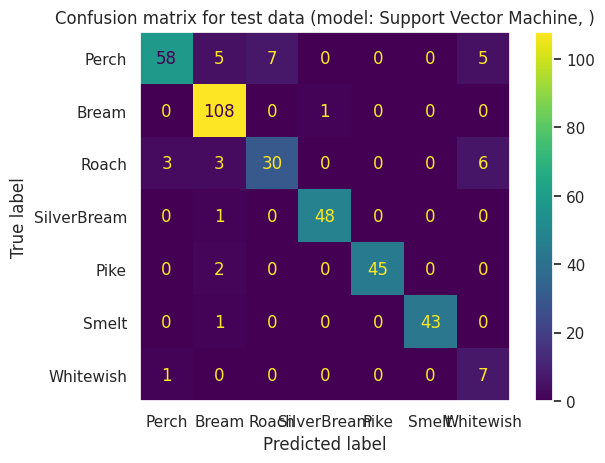

Classification Report for test data (, model: Support Vector Machine) 
               precision    recall  f1-score   support

       Perch       0.94      0.77      0.85        75
       Bream       0.90      0.99      0.94       109
       Roach       0.81      0.71      0.76        42
 SilverBream       0.98      0.98      0.98        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.39      0.88      0.54         8

    accuracy                           0.91       374
   macro avg       0.86      0.90      0.86       374
weighted avg       0.92      0.91      0.91       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for K-Nearest Neighbors: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best CV f1-macro score: 0.9050522220710268
Test f1 macro Score: 0.91518598563829

<Figure size 1200x800 with 0 Axes>

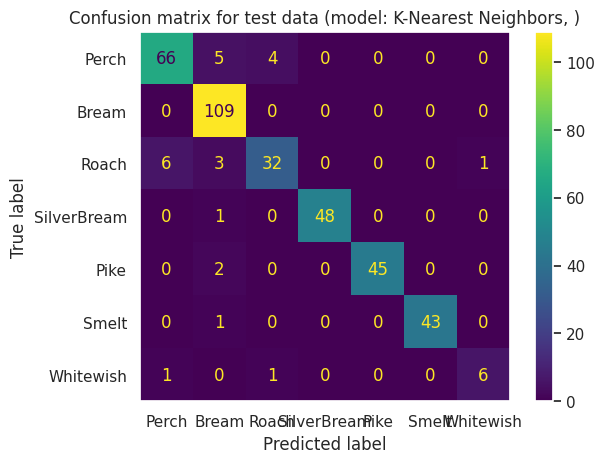

Classification Report for test data (, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

       Perch       0.90      0.88      0.89        75
       Bream       0.90      1.00      0.95       109
       Roach       0.86      0.76      0.81        42
 SilverBream       1.00      0.98      0.99        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.86      0.75      0.80         8

    accuracy                           0.93       374
   macro avg       0.93      0.90      0.92       374
weighted avg       0.93      0.93      0.93       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Gradient Boosting: {'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best CV f1-macro score: 0.8577261543329995
Test f1 macro Score: 0.8706594402723313


<Figure size 1200x800 with 0 Axes>

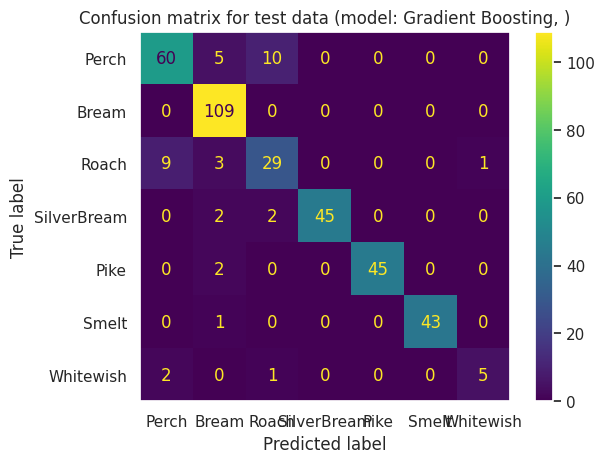

Classification Report for test data (, model: Gradient Boosting) 
               precision    recall  f1-score   support

       Perch       0.85      0.80      0.82        75
       Bream       0.89      1.00      0.94       109
       Roach       0.69      0.69      0.69        42
 SilverBream       1.00      0.92      0.96        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.83      0.62      0.71         8

    accuracy                           0.90       374
   macro avg       0.89      0.85      0.87       374
weighted avg       0.90      0.90      0.90       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best CV f1-macro score: 0.8666312052068341
Test f1 macro Score: 0.9065778470719285


<Figure size 1200x800 with 0 Axes>

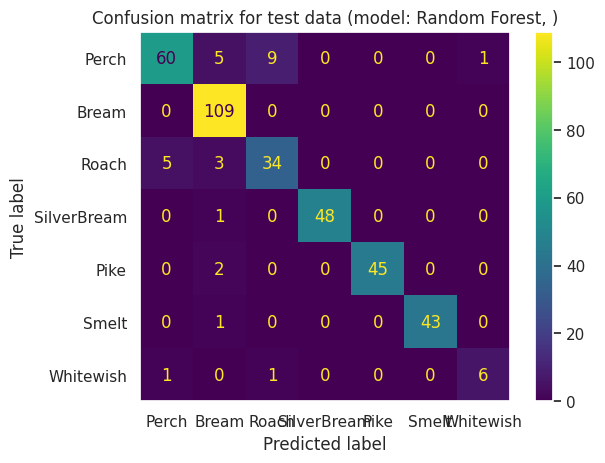

Classification Report for test data (, model: Random Forest) 
               precision    recall  f1-score   support

       Perch       0.91      0.80      0.85        75
       Bream       0.90      1.00      0.95       109
       Roach       0.77      0.81      0.79        42
 SilverBream       1.00      0.98      0.99        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.86      0.75      0.80         8

    accuracy                           0.92       374
   macro avg       0.92      0.90      0.91       374
weighted avg       0.92      0.92      0.92       374

--------------------------------------------------




['results_fish.joblib']

In [131]:
# Evaluate models
results_fish = run_main(models_map, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
dump(results_fish, 'results_fish.joblib')

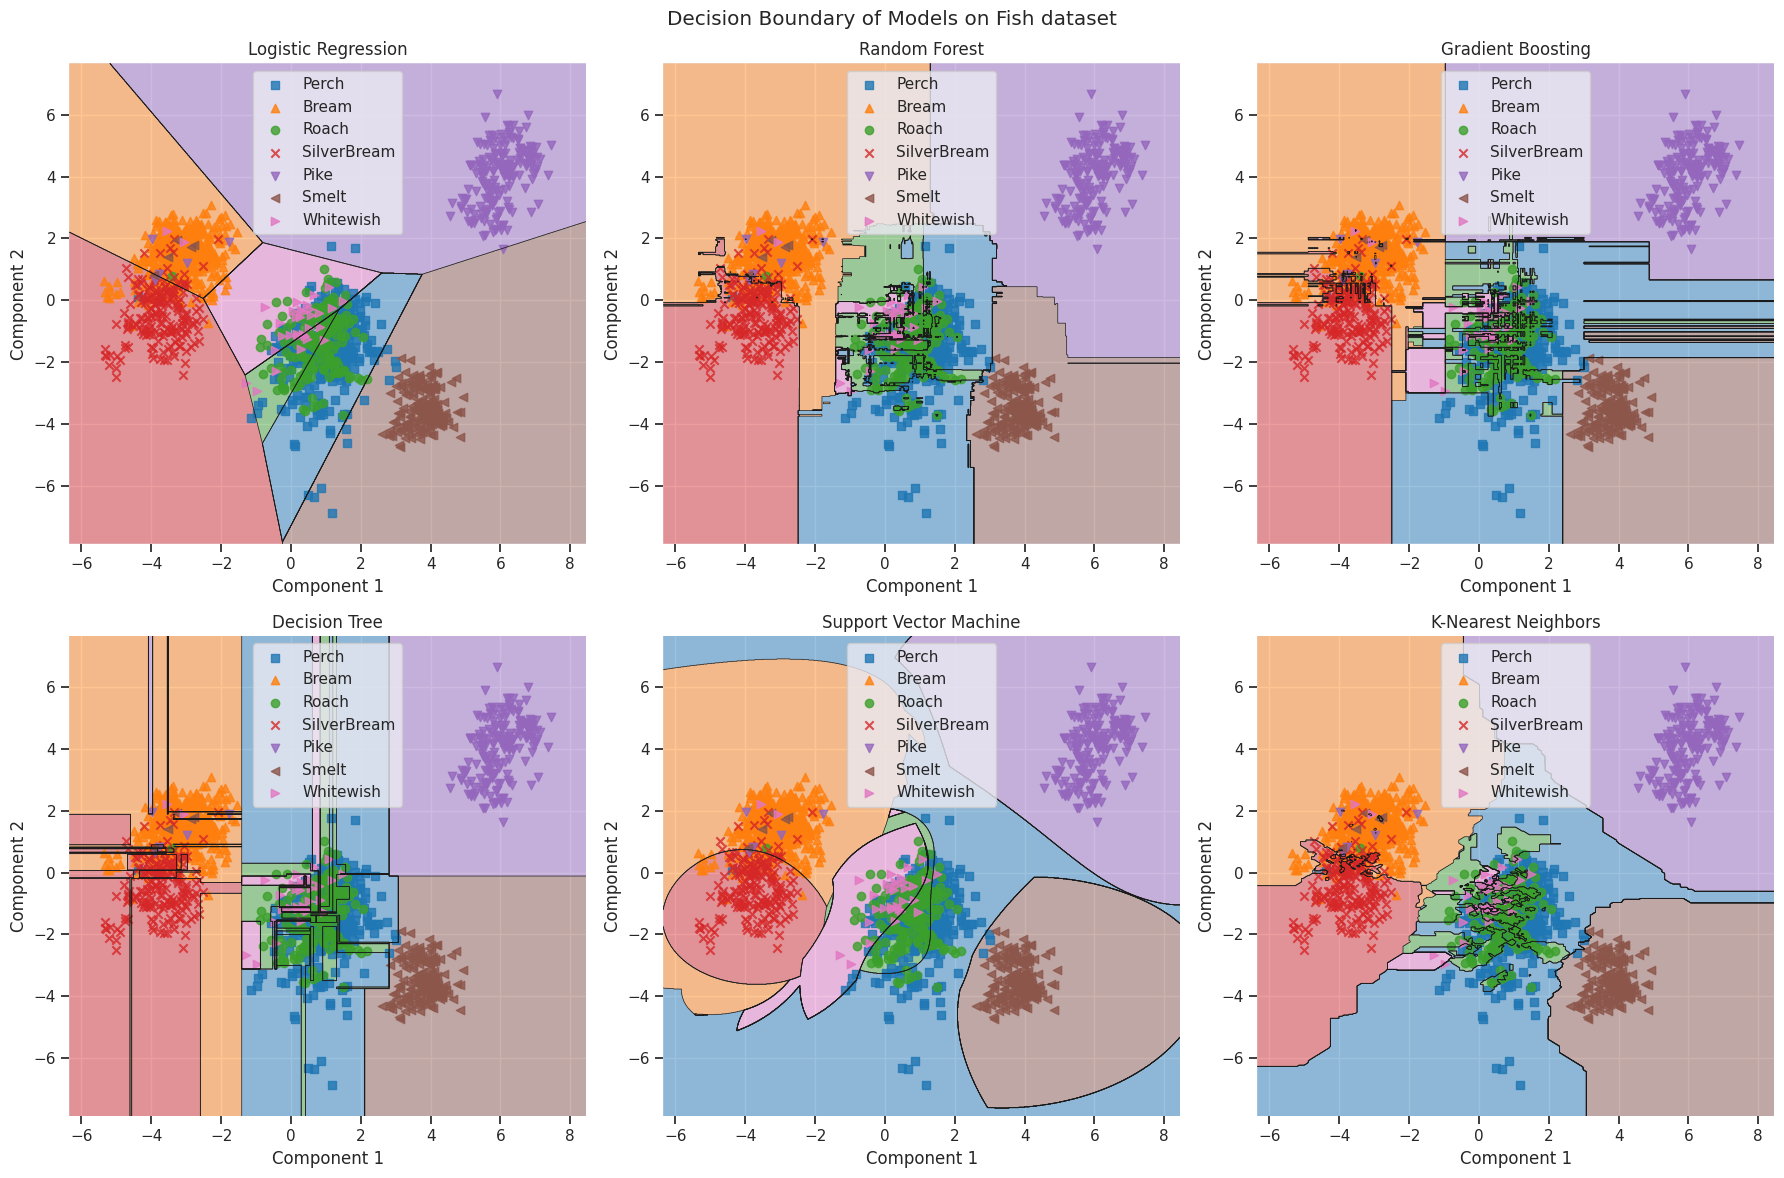

In [133]:
plt_decision_boundary(X_train, Y_train, results_fish, title='Decision Boundary of Models on Fish dataset')

In [134]:
# check the besst hyoeprparameters for each model
for key, result in results_fish.items():
    print(f"Best hyperparameters for {result['model_name']}: {result['grid_search_res'].best_params_}")

Best hyperparameters for Logistic Regression: {'classifier__C': 10}
Best hyperparameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best hyperparameters for Support Vector Machine: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best hyperparameters for K-Nearest Neighbors: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best hyperparameters for Gradient Boosting: {'classifier__learning_rate': 1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best hyperparameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


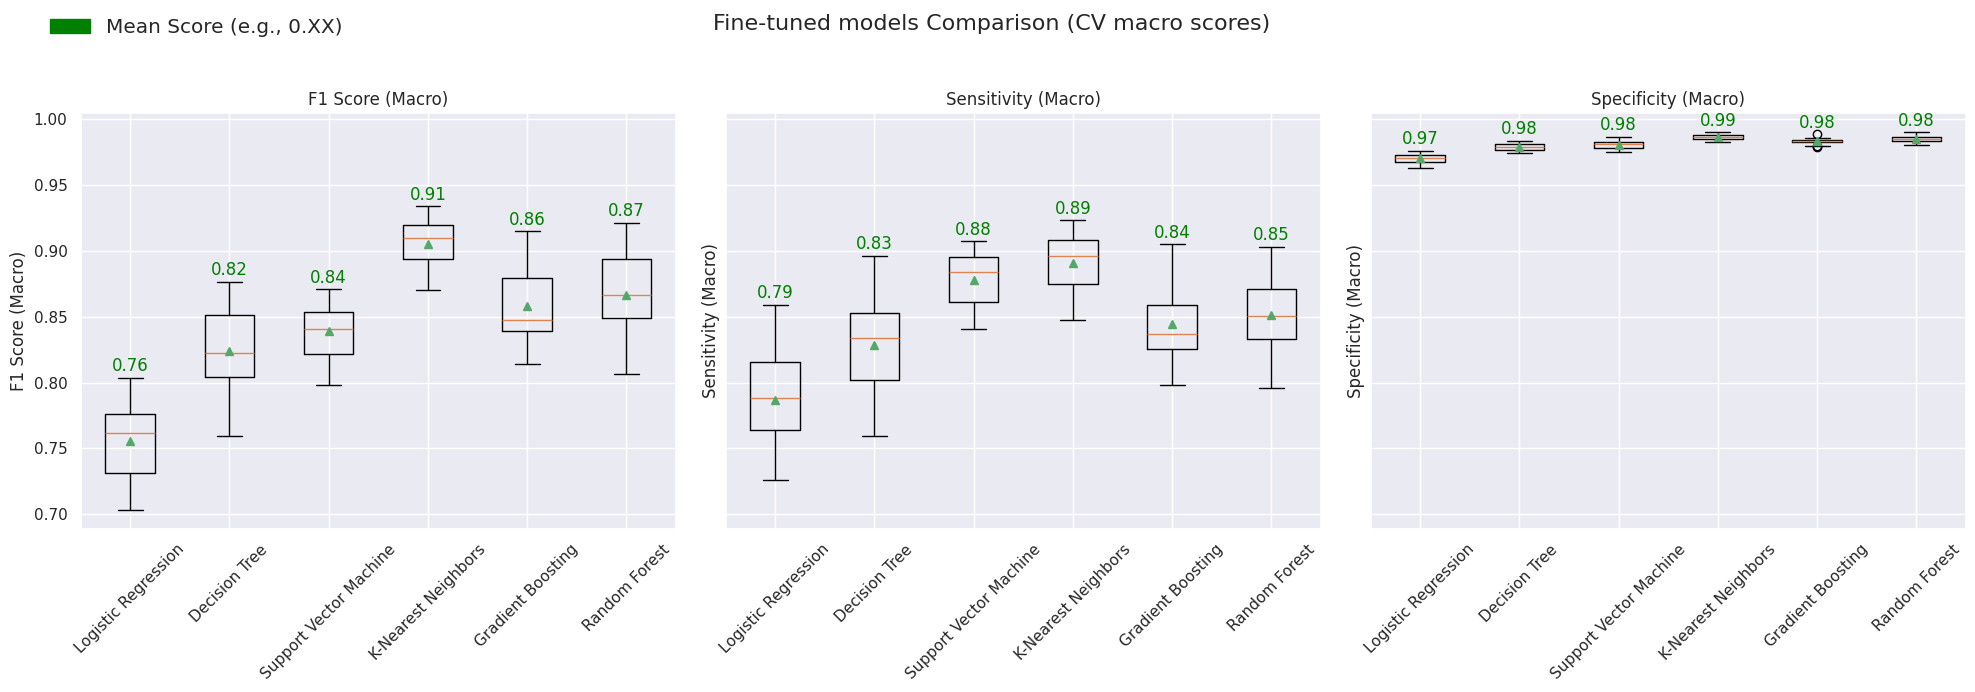

In [135]:
plot_cv_results(results_fish, title='Fine-tuned models Comparison (CV macro scores)')

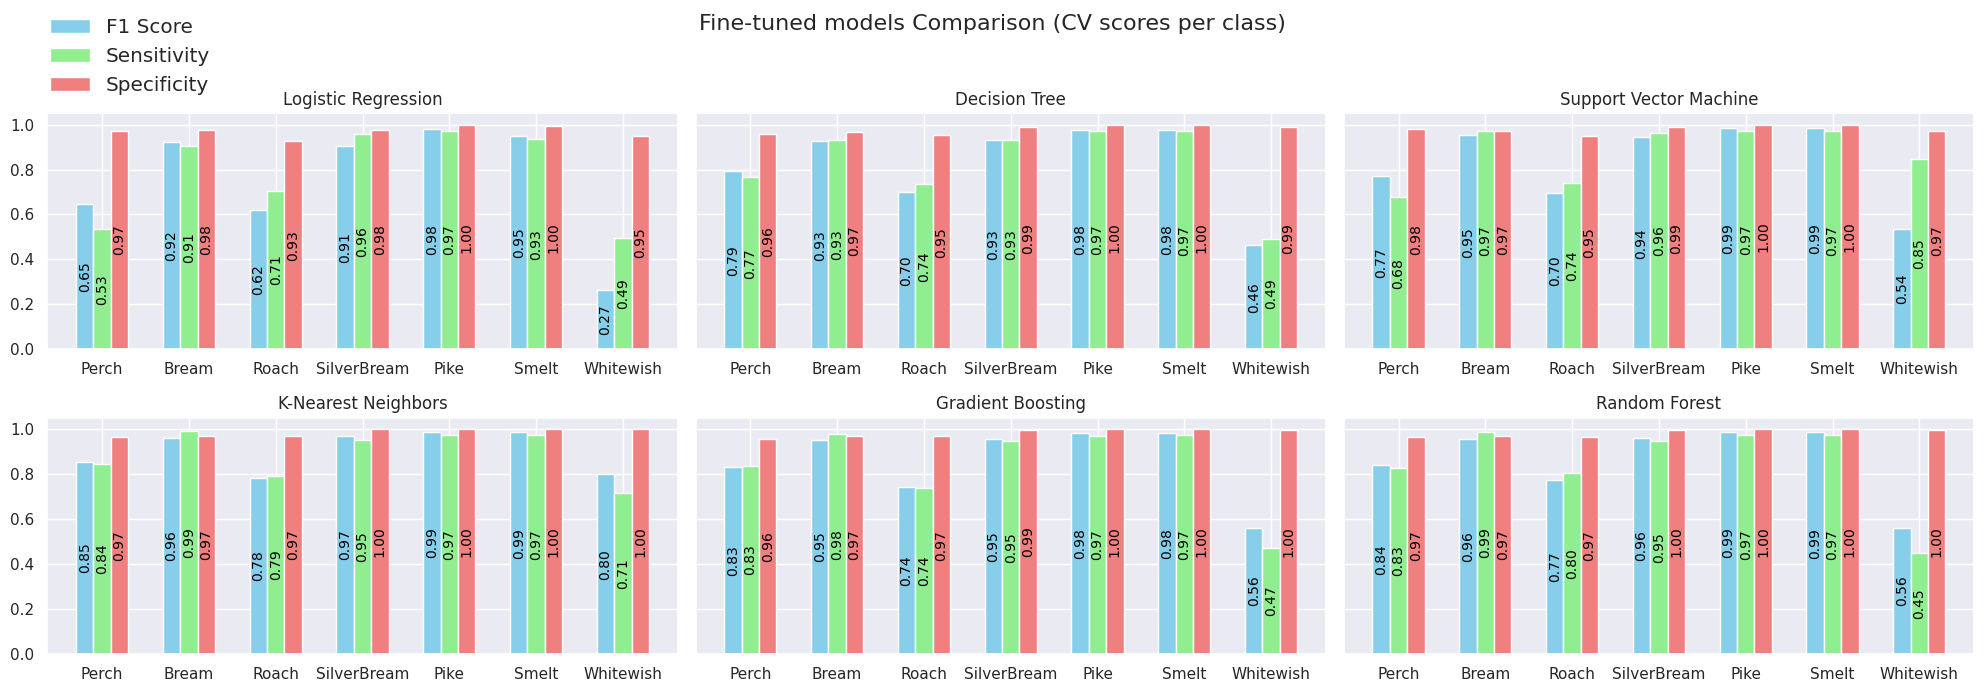

In [136]:
plot_class_cv_results(results_fish, title='Fine-tuned models Comparison (CV scores per class)') 

### SMOTE

/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/



**************************************************
**RESULTS SUMMARY**



Model                  Logistic Regression  Decision Tree  \
CV F1 score (macro)               0.736692       0.808632   
Test F1 score (macro)             0.781047       0.857847   

Model                  Support Vector Machine  K-Nearest Neighbors  \
CV F1 score (macro)                  0.792917             0.873653   
Test F1 score (macro)                0.875659             0.898091   

Model                  Gradient Boosting  Random Forest  
CV F1 score (macro)             0.846556       0.872085  
Test F1 score (macro)           0.865854       0.913642

**************************************************


--------------------------------------------------
Best parameters found for Logistic Regression: {'classifier__C': 10}
Best CV f1-macro score: 0.7618642446981836
Test f1 macro Score: 0.7810468772528228


<Figure size 1200x800 with 0 Axes>

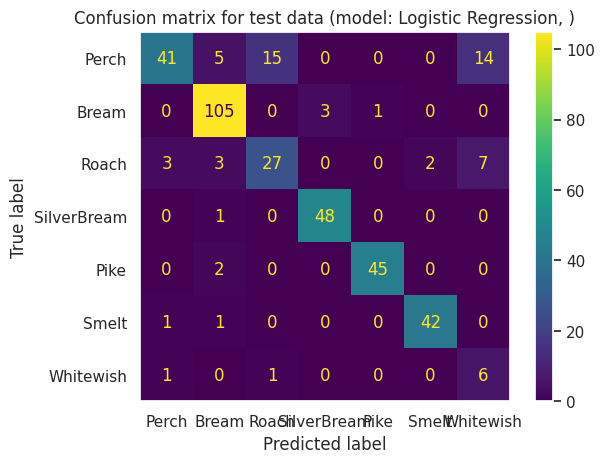

Classification Report for test data (, model: Logistic Regression) 
               precision    recall  f1-score   support

       Perch       0.89      0.55      0.68        75
       Bream       0.90      0.96      0.93       109
       Roach       0.63      0.64      0.64        42
 SilverBream       0.94      0.98      0.96        49
        Pike       0.98      0.96      0.97        47
       Smelt       0.95      0.95      0.95        44
   Whitewish       0.22      0.75      0.34         8

    accuracy                           0.84       374
   macro avg       0.79      0.83      0.78       374
weighted avg       0.87      0.84      0.85       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5}
Best CV f1-macro score: 0.8253508237700795
Test f1 macro Score: 0.857847358380872


<Figure size 1200x800 with 0 Axes>

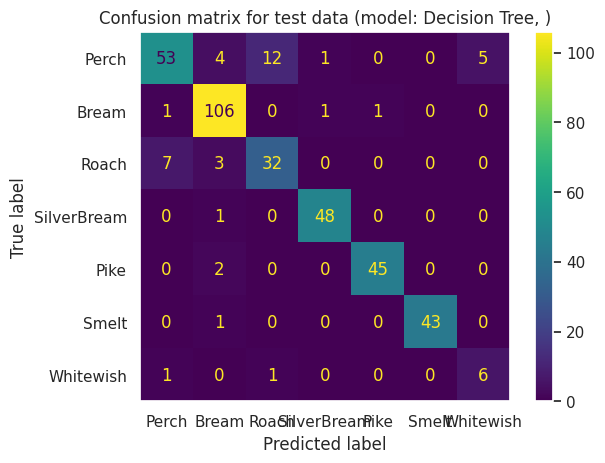

Classification Report for test data (, model: Decision Tree) 
               precision    recall  f1-score   support

       Perch       0.85      0.71      0.77        75
       Bream       0.91      0.97      0.94       109
       Roach       0.71      0.76      0.74        42
 SilverBream       0.96      0.98      0.97        49
        Pike       0.98      0.96      0.97        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.55      0.75      0.63         8

    accuracy                           0.89       374
   macro avg       0.85      0.87      0.86       374
weighted avg       0.89      0.89      0.89       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Support Vector Machine: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best CV f1-macro score: 0.8475707589509206
Test f1 macro Score: 0.8756593722143581


<Figure size 1200x800 with 0 Axes>

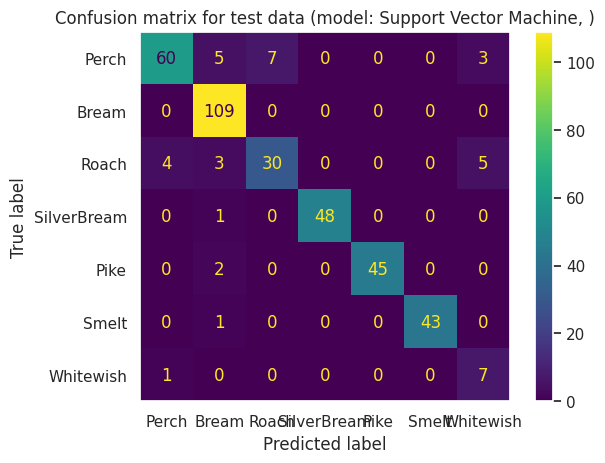

Classification Report for test data (, model: Support Vector Machine) 
               precision    recall  f1-score   support

       Perch       0.92      0.80      0.86        75
       Bream       0.90      1.00      0.95       109
       Roach       0.81      0.71      0.76        42
 SilverBream       1.00      0.98      0.99        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.47      0.88      0.61         8

    accuracy                           0.91       374
   macro avg       0.87      0.90      0.88       374
weighted avg       0.92      0.91      0.92       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for K-Nearest Neighbors: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
Best CV f1-macro score: 0.8814775373281205
Test f1 macro Score: 0.8980909678917

<Figure size 1200x800 with 0 Axes>

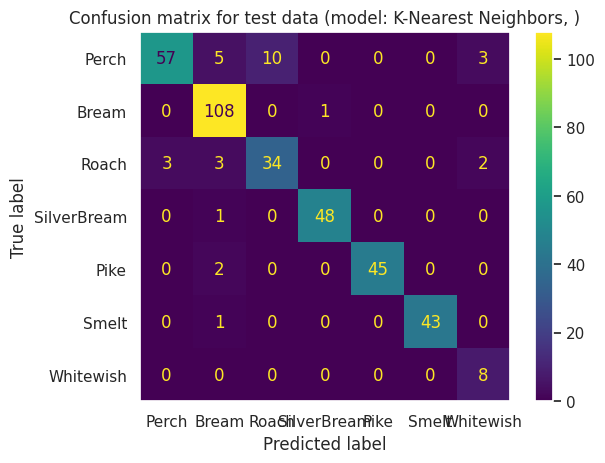

Classification Report for test data (, model: K-Nearest Neighbors) 
               precision    recall  f1-score   support

       Perch       0.95      0.76      0.84        75
       Bream       0.90      0.99      0.94       109
       Roach       0.77      0.81      0.79        42
 SilverBream       0.98      0.98      0.98        49
        Pike       1.00      0.96      0.98        47
       Smelt       1.00      0.98      0.99        44
   Whitewish       0.62      1.00      0.76         8

    accuracy                           0.92       374
   macro avg       0.89      0.92      0.90       374
weighted avg       0.92      0.92      0.92       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Gradient Boosting: {'classifier__learning_rate': 1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50}
Best CV f1-macro score: 0.8621907283414297
Test f1 macro Score: 0.8658540649013844


<Figure size 1200x800 with 0 Axes>

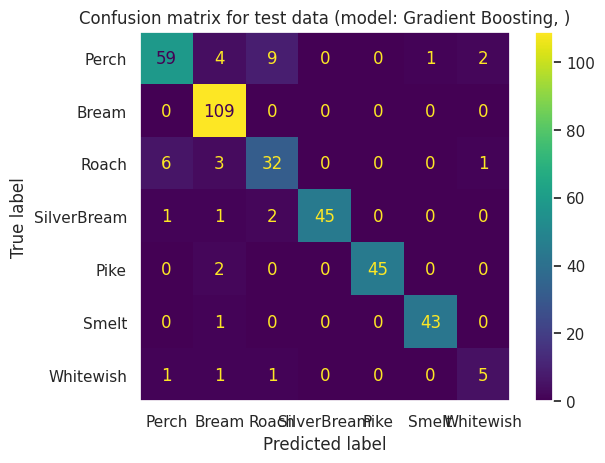

Classification Report for test data (, model: Gradient Boosting) 
               precision    recall  f1-score   support

       Perch       0.88      0.79      0.83        75
       Bream       0.90      1.00      0.95       109
       Roach       0.73      0.76      0.74        42
 SilverBream       1.00      0.92      0.96        49
        Pike       1.00      0.96      0.98        47
       Smelt       0.98      0.98      0.98        44
   Whitewish       0.62      0.62      0.62         8

    accuracy                           0.90       374
   macro avg       0.87      0.86      0.87       374
weighted avg       0.91      0.90      0.90       374

--------------------------------------------------


--------------------------------------------------
Best parameters found for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV f1-macro score: 0.8749749465687802
Test f1 macro Score: 0.9136415474612118


<Figure size 1200x800 with 0 Axes>

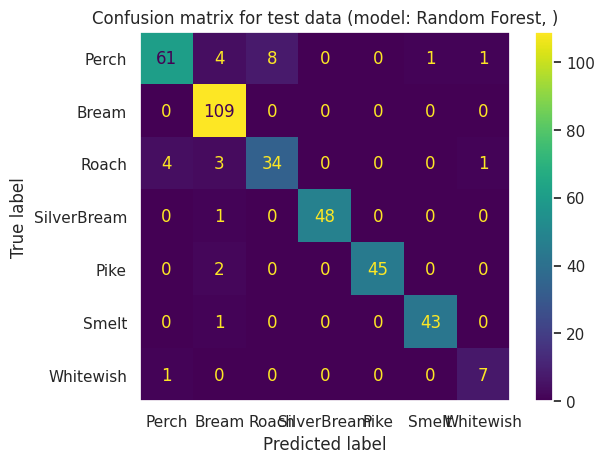

Classification Report for test data (, model: Random Forest) 
               precision    recall  f1-score   support

       Perch       0.92      0.81      0.87        75
       Bream       0.91      1.00      0.95       109
       Roach       0.81      0.81      0.81        42
 SilverBream       1.00      0.98      0.99        49
        Pike       1.00      0.96      0.98        47
       Smelt       0.98      0.98      0.98        44
   Whitewish       0.78      0.88      0.82         8

    accuracy                           0.93       374
   macro avg       0.91      0.92      0.91       374
weighted avg       0.93      0.93      0.93       374

--------------------------------------------------




['results_smote.joblib']

In [137]:
from sklearn.neighbors import NearestNeighbors

smote = SMOTE(
  random_state=random_state,  
  k_neighbors=NearestNeighbors(n_jobs=-1, n_neighbors=3, metric='manhattan'),
  sampling_strategy='all'
)
results_smote = run_main(models_map, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, imb_handler=smote)
dump(results_smote, 'results_smote.joblib')

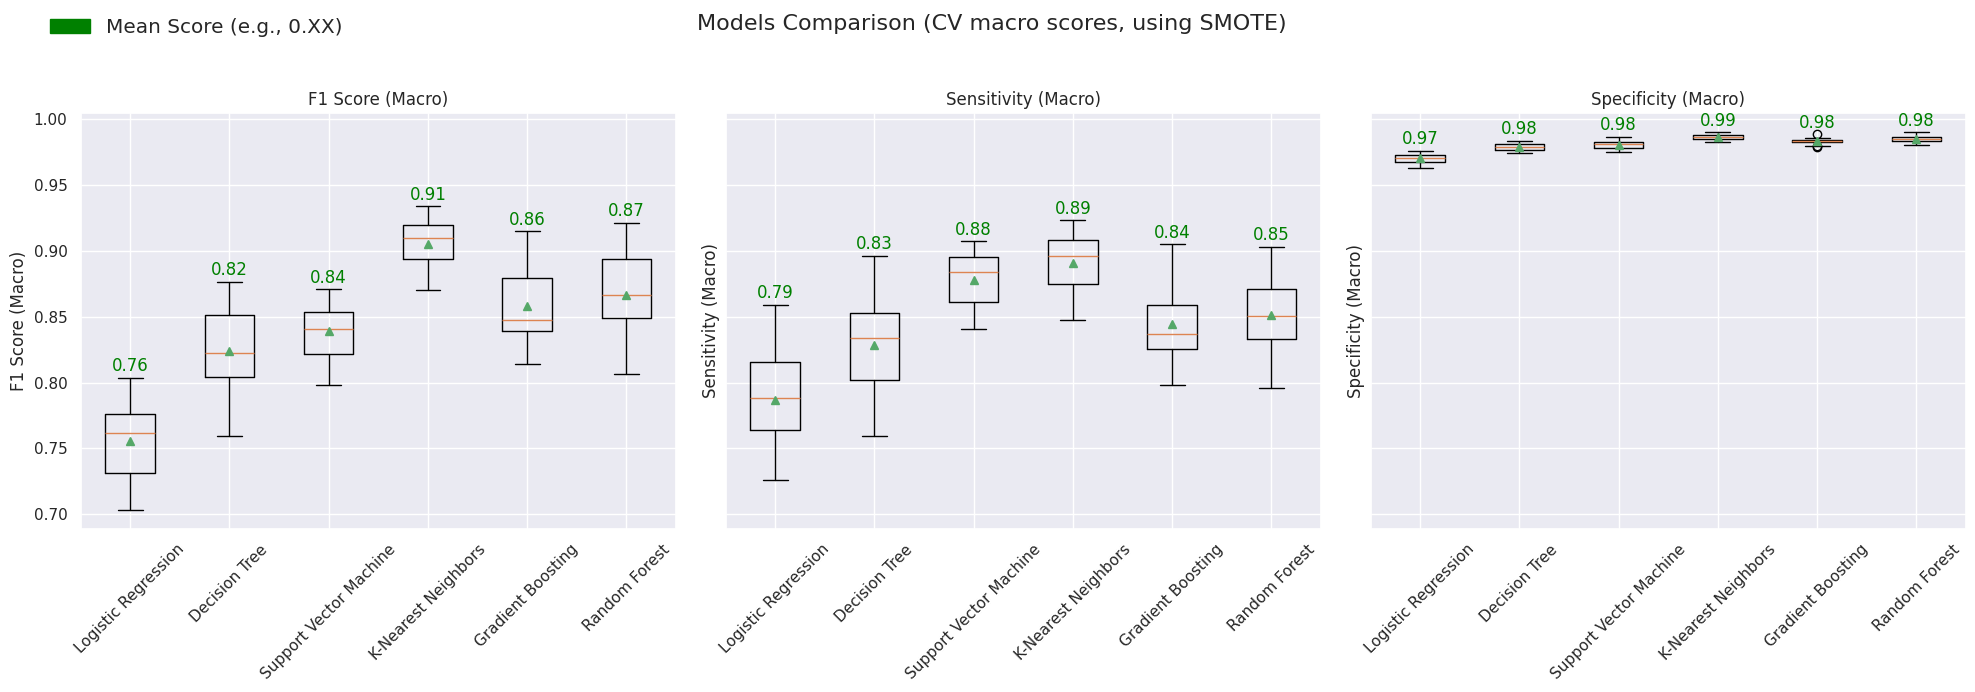

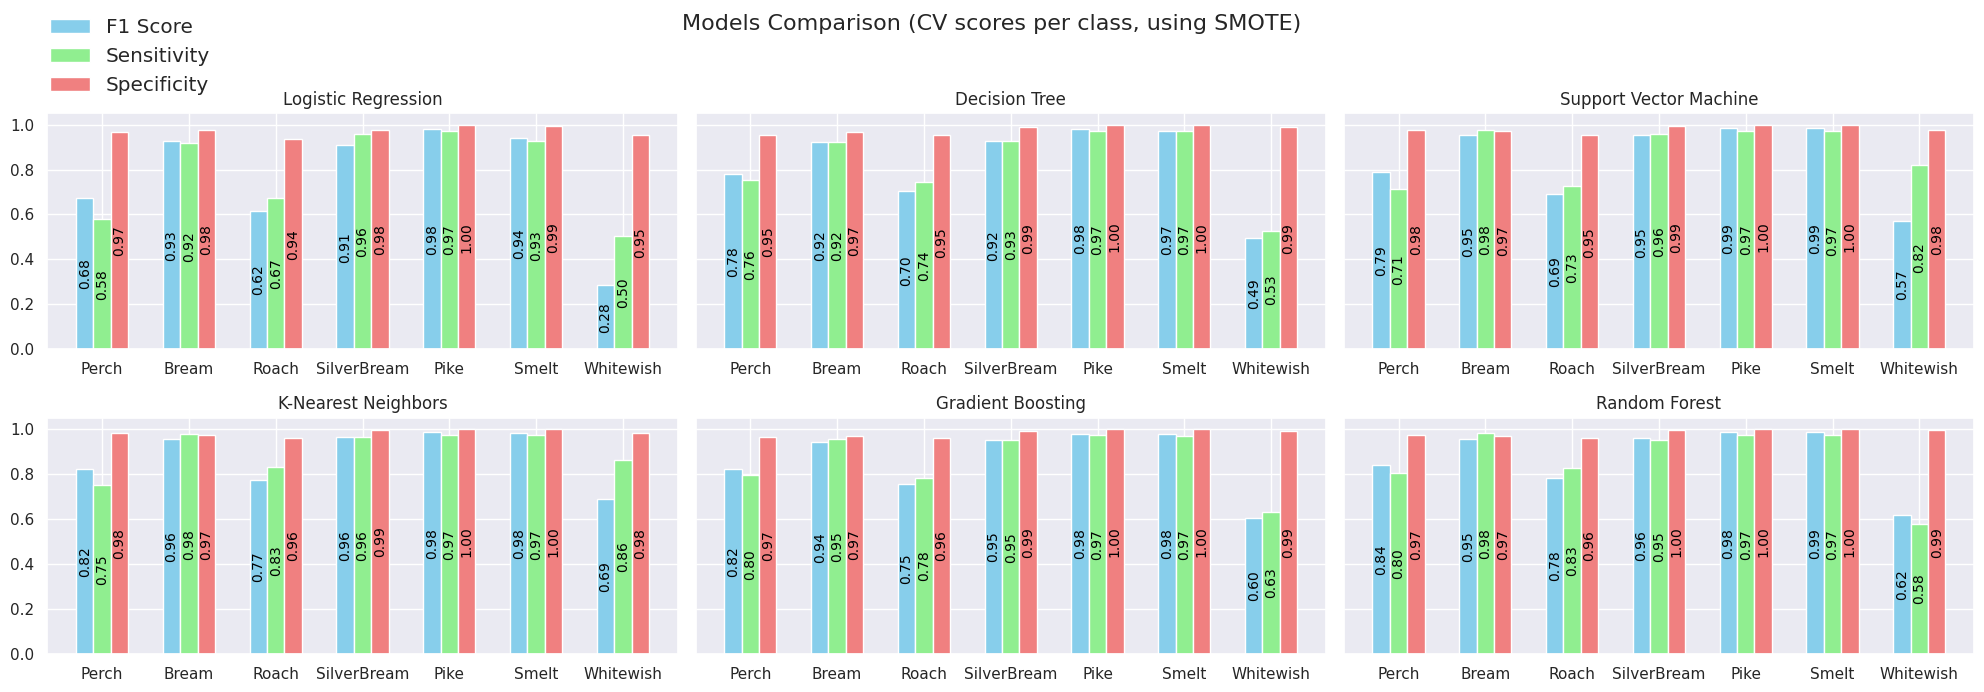

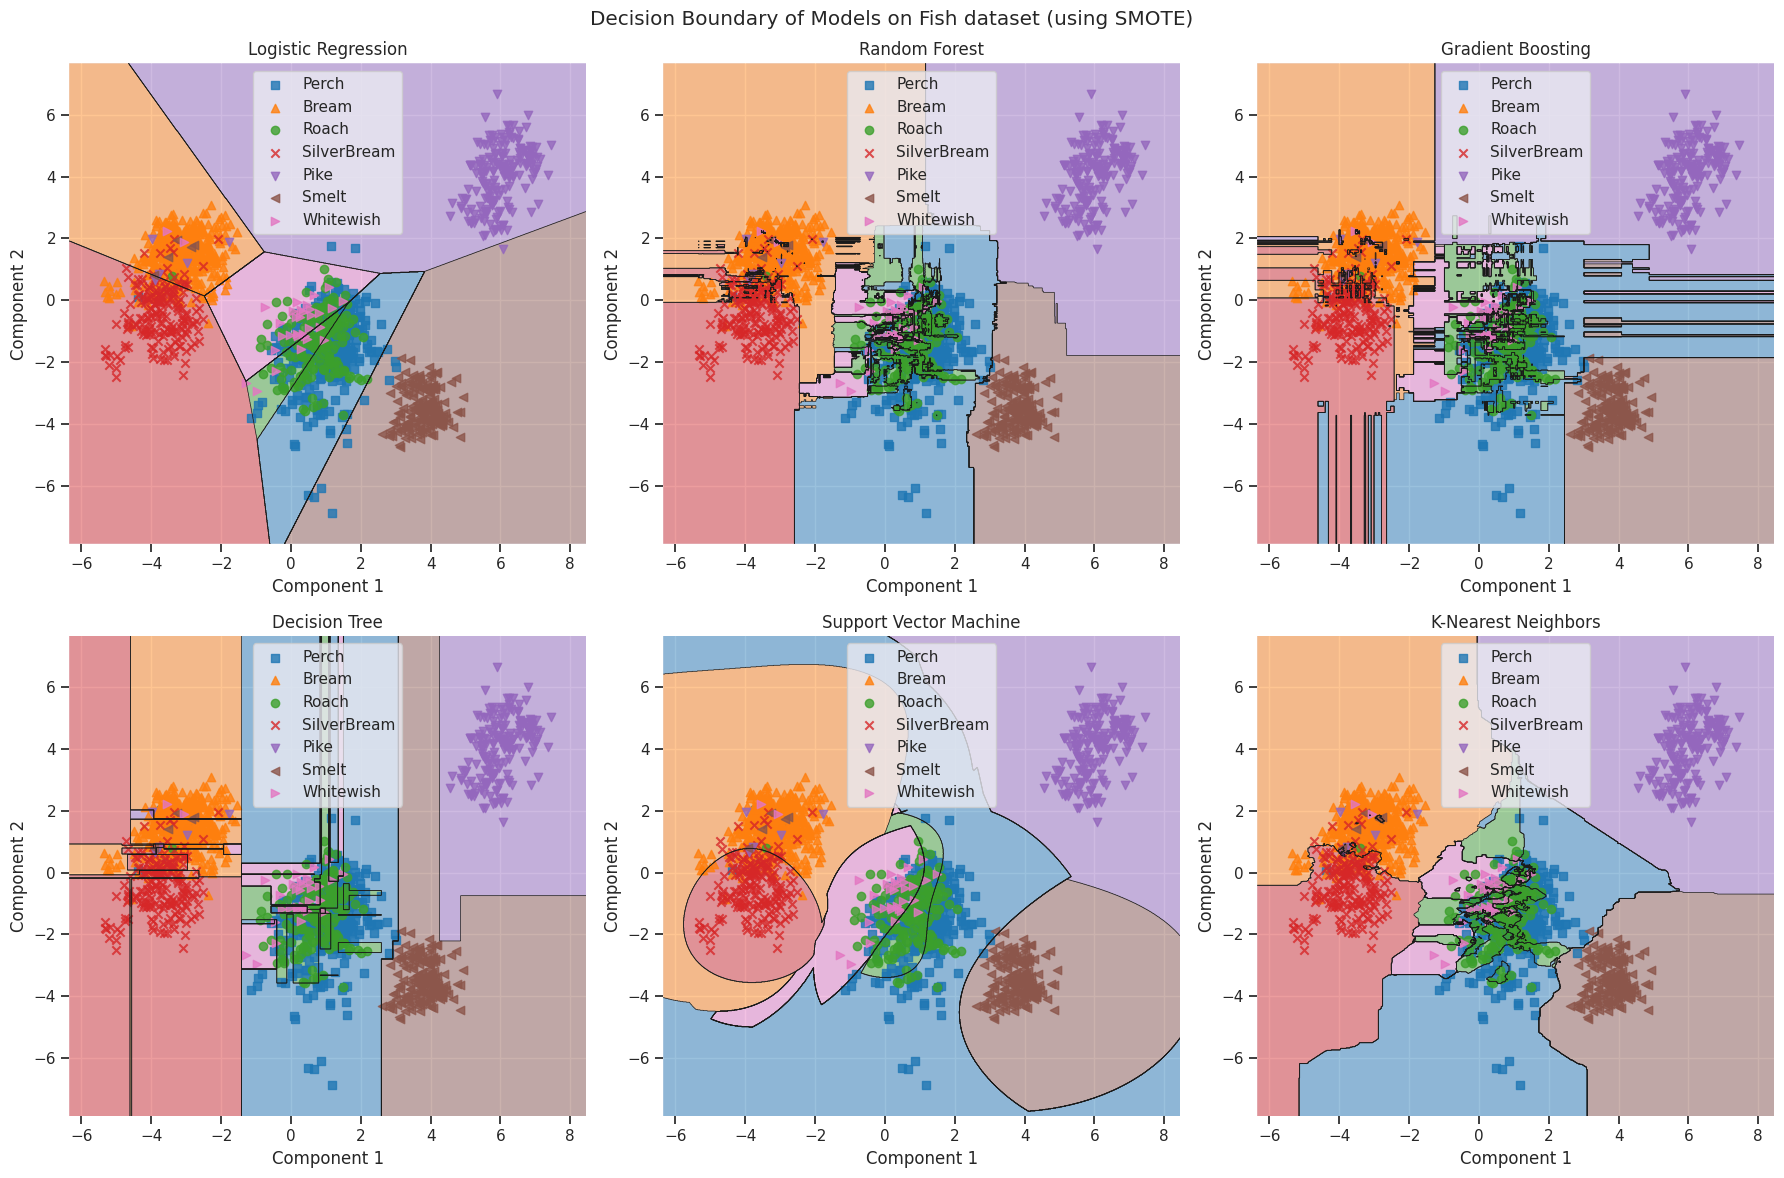

In [138]:
plot_cv_results(results_fish, title='Models Comparison (CV macro scores, using SMOTE)')
plot_class_cv_results(results_smote, title='Models Comparison (CV scores per class, using SMOTE)')
plt_decision_boundary(X_train, Y_train, results_smote, title='Decision Boundary of Models on Fish dataset (using SMOTE)')

### Condensed Nearest Neighbor

In [139]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=random_state, n_jobs=-1)
results_cnn = run_main(models_map, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, imb_handler=cnn)

In [ ]:
plot_cv_results(results_cnn, title='Model Comparison (Fish dataset with CNN)', ylabel='F1 Score (Macro)')
plot_class_cv_results(results_cnn, title='Model Comparison (Fish dataset with CNN)')
plt_decision_boundary(X_train, Y_train, results_cnn, title='Decision Boundary of Models on Fish dataset (using CNN)')

## 1b